In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import os

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

1. Вычленить данные 
    - считывание данных из папок пользователя ✅
2. Преобраование данных. 
    - разделение на левую и правую части клавиатуры ✅
    - средняя сила нажатия (левая/правая рука) ✅
    - скорость печати ✅
    - количество опечаток ✅
3. Обучение модели. 
    - Составление вектора для обучения ✅
    - Многослойный перцептрон (MLPClassifier) ✅
4. Получение результата. 

### Извлечение признаков, работа с данными

In [8]:
keyCodes = {}

file1 = open('Keyboard_key_codes.txt', 'r')

for line in file1:
    keyPair = line.strip()
    keyPair = keyPair.split(" - ")
    keyCodes[keyPair[0]] = keyPair[1]
file1.close()
keyCodes["192"] = "Backquote"

In [9]:
leftSideKeyList = [
    "Q", "W", "E",  "R", "T", "A", "S", "D",
    "F", "G", "Z", "X", "C", "V", "B", "1", "2",
    "3", "4", "5", "6", "Caps Lock", "Esc", "Tab", "Space",
    "left Win", "left Shift", "left Ctrl", "F1", "F2", "F3", "F4", "F5", "Backquote"
    ]

leftSideKeyCodeList = []
for key in keyCodes:
    if (keyCodes[key] in leftSideKeyList):
        leftSideKeyCodeList.append(int(key))

specialKeys = [
    "left Win", "left Shift", "left Ctrl", "F1", "F2", "F3", "F4", "F5", "Backquote",
    "Backspace", "Enter", "Shift", "Ctrl", "Alt", "Pause/Break", "Page Up", "Page Up",
    "Space", "Page Down", "End", "Home", "Left arrow", "Up arrow", "Right arrow",
    "Down arrow", "Print Screen", "Insert", "Delete", "right Win", "Popup", "Num Lock",
    "Scroll Lock", "right Shift", "right Ctrl",
    "0 in the numeric keypad", "1 in the numeric keypad", "2 in the numeric keypad",
    "3 in the numeric keypad", "4 in the numeric keypad", "5 in the numeric keypad",
    "6 in the numeric keypad", "7 in the numeric keypad", "8 in the numeric keypad",
    "9 in the numeric keypad", "* in the numeric keypad", "+ in the numeric keypad",
    "- in the numeric keypad", ". in the numeric keypad", "/ in the numeric keypad "
]

specialKeyCodes = []
for key in keyCodes:
    if (keyCodes[key] in specialKeys):
        specialKeyCodes.append(int(key))

In [10]:
sourcePath = "../keylogger/Project3/sqlite-data/"

In [70]:
def getUsersFiles(start_path='.'):
    dataFiles = {}
    for root, dirs, _ in os.walk(start_path):
        for dir in dirs:
            for genValues in  os.walk(os.path.join(root, dir)):
                dataFilesList = []
                filesInDir = genValues[2]
                for dataFile in filesInDir:
                    dataFilesList.append(os.path.join(genValues[0], dataFile))
                dataFiles[dir] = dataFilesList
        break
    return dataFiles

def getDataFrameFromDataBase(dbFileName):
    con = sqlite3.connect(dbFileName)
    dataFrame = pd.read_sql_query("SELECT * from Keyboard", con)
    return dataFrame

#--------------------------------------------------------------------------------------

def getLeftSideDf(dataFrame):
    leftSideDf = dataFrame.loc[(dataFrame["key"].isin(leftSideKeyCodeList))]
    leftSideDf.reset_index(inplace = True, drop = True)
    return leftSideDf

def getRightSideDf(dataFrame):
    rigthSideDf = dataFrame.loc[(~dataFrame["key"].isin(leftSideKeyCodeList))]
    rigthSideDf.reset_index(inplace = True, drop = True)
    return rigthSideDf

def getPushDownsKeys(dataFrame):
    pushDownsDf = dataFrame.loc[(dataFrame["pressing"] == 0)]
    pushDownsDf.reset_index(inplace = True, drop = True)
    return pushDownsDf

def getPrintSpeedOfDf(dataFrame):
    borderLinesOfDf = dataFrame.iloc[[0, -1]]
    timeSegmentLimits = borderLinesOfDf['time'].to_list()
    startTime = timeSegmentLimits[0]
    endTime = timeSegmentLimits[1]
    linesCount = dataFrame.shape[0]
    return (endTime - startTime) / linesCount

def getDfWithoutSpecialKeys(dataFrame):
    defaultKeysDf = dataFrame.loc[(~dataFrame["key"].isin(specialKeyCodes))]
    defaultKeysDf.reset_index(inplace = True, drop = True)
    return defaultKeysDf

def getTypoCount(dataFrame):
    return dataFrame.loc[(dataFrame["key"] == 8) | (dataFrame["key"] == 46)].shape[0]

def getTypoRate(dataFrame):
    return getTypoCount(dataFrame) / dataFrame.shape[0]

def getAvgPressingsOfDf(dataFrame):
    if len(dataFrame) == 0:
        return 0, 0
    pressingCount = 0
    pressingSum = 0
    maxPressing = 0

    for i in range(len(dataFrame)):
        line = dataFrame.loc[i]
        if line['pressing'] == 1:
            for j in range(i - 1, -1, -1):
                jline = dataFrame.loc[j]
                if (jline['key'] == line['key']) and (jline['pressing'] == 0):
                    pressingTime = line['time'] - jline['time']
                    pressingCount += 1
                    pressingSum += pressingTime
                    if maxPressing < pressingTime:
                        maxPressing = pressingTime
                    break

    totalKeyUsage = dataFrame.shape[0] - pressingCount
    avgPressing = pressingSum / totalKeyUsage
    return avgPressing, maxPressing

def getCaseParameters(dataFrame):
    params = []

    printSpeed = getPrintSpeedOfDf(dataFrame)
    params.append(printSpeed)

    typoRate = getTypoRate(dataFrame)
    params.append(typoRate)

    dfWoSpecKeys = getDfWithoutSpecialKeys(dataFrame)

    avgPressings, _ = getAvgPressingsOfDf(dfWoSpecKeys)
    params.append(avgPressings)

    lDf = getLeftSideDf(dfWoSpecKeys)
    lAvgPressing, lMaxPressing = getAvgPressingsOfDf(lDf)
    params.append(lAvgPressing)

    rDf = getRightSideDf(dfWoSpecKeys)
    rAvgPressing, rMaxPressing = getAvgPressingsOfDf(rDf)
    params.append(rAvgPressing)

    return params


#---------------------------------------------------------------------------------


def processUserData(userData):
    userParams = []
    for file in userData:
        db = getDataFrameFromDataBase(file)
        params = getCaseParameters(db)
        userParams.append(params)

    return userParams

def getUsersData(usersFiles):
    usersData = {}
    userIndex = 0

    usersDict = {}

    for user in usersFiles:
        userParams = processUserData(usersFiles[user])
        usersData[userIndex] = userParams
        usersDict[userIndex] = user
        userIndex += 1

    reversedUsersDict = getReversedUsersDict(usersDict)
    return usersData, usersDict, reversedUsersDict

def getReversedUsersDict(usersDict):
    reversedDict = {}
    for key in usersDict:
        reversedDict[usersDict[key]] = key

    return reversedDict

def turnToFitData(usersData):
    x_params = []
    y_params = []
    for user in usersData:
        x_params += usersData[user]
        y_params += [user] * len(usersData[user])

    return x_params, y_params

# ----------------------------------------------------------------------------
def getUsersInfo():
    usersFiles = getUsersFiles(sourcePath)
    usersData, usersDict, revDict = getUsersData(usersFiles)

    avgDateList = []
    for u in usersData:
        dataList = [0, 0, 0, 0, 0]
        for d in usersData[u]:
            dataList[0] += d[0] / len(usersData[u])
            dataList[1] += d[1] / len(usersData[u])
            dataList[2] += d[2] / len(usersData[u])
            dataList[3] += d[3] / len(usersData[u])
            dataList[4] += d[4] / len(usersData[u])
        avgDateList.append(dataList.copy())

    kek = np.array(avgDateList)
    tkek = kek.transpose()

    param0 = [i/6 for i in range(200 * 6, 501 * 6, 300)]
    param1 = [i/6/100 for i in range(5 * 6, 51 * 6, 45)]
    param2 = [i/6 for i in range(2 * 6, 19 * 6, 16)]
    param3 = [i/6 for i in range(2 * 6, 19 * 6, 16)]
    param4 = [i/6 for i in range(2 * 6, 19 * 6, 16)]

    steps = []
    steps.append((500 - 200) / 6)
    steps.append((50 - 5) / 6 / 100)
    steps.append((19 - 2) / 6)
    steps.append((19 - 2) / 6)
    steps.append((19 - 2) / 6)

    import random
    from scipy.stats import norm

    users = {0 : [466.10297685384904, 0.008185948681076291, 13.098670902756133, 14.827733067039274, 10.941874069696174],
            1 : [316.2627162241687, 0.02426126841461837, 5.213536744394283, 8.112372966835073, 1.7774030243217074],
            2 : [310.01346124709306, 0.0048371959709933845, 14.201844305342567, 11.794154238736624, 17.42058946318019],}

    for i in range(3, 21):
        u = []
        u.append(random.choice(param0) + random.random() * 25 - 12)
        u.append(random.choice(param1) + random.random() * 0.038 - 0.019)
        u.append(random.choice(param2) + random.random() * 2.4 - 1.2)
        u.append(random.choice(param3) + random.random() * 2.4 - 1.2)
        u.append(random.choice(param4) + random.random() * 2.4 - 1.2)
        users[i] = u

    newUsers = {}
    for userId in users:
        udata = []
        for i in range(30):
            urec = []
            stepId = 0
            for p in users[userId]:
                # urec.append(random.random() * steps[stepId] * 1.2 - steps[stepId] * 0.6 + p)
                urec.append(abs(norm.rvs(p, scale=(steps[stepId] * 0.4))))
                stepId += 1

            udata.append(urec)

        newUsers[userId] = udata
    usersData = newUsers

    return usersData


### Определение лучших параметров классификатора

In [10]:
usersFiles = getUsersFiles(sourcePath)
usersData, usersDict, revDict = getUsersData(usersFiles)
X, y = turnToFitData(usersData)

In [450]:
X, y = turnToFitData(usersData)

In [451]:
scores = []
best_solution = []
max_score = 0
for act in ['identity', 'logistic', 'tanh', 'relu']:
    for slvr in ['lbfgs', 'sgd', 'adam']:
        score_result = []
        for i in range(100):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

            clf = MLPClassifier(random_state=1, max_iter=1000, solver=slvr, activation=act).fit(X_train, y_train)
            res = clf.score(X_test, y_test)
            score_result.append(res)

        if np.mean(score_result) > max_score:
            best_solution.append([act, slvr, np.mean(score_result)])

print(best_solution)

f:\python3.10.11\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
f:\python3.10.11\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
f:\python3.10.11\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



[['identity', 'lbfgs', 0.8940833333333333], ['identity', 'sgd', 0.047749999999999994], ['identity', 'adam', 0.8248333333333333], ['logistic', 'lbfgs', 0.5471666666666667], ['logistic', 'sgd', 0.4520833333333333], ['logistic', 'adam', 0.9658333333333333], ['tanh', 'lbfgs', 0.43200000000000005], ['tanh', 'sgd', 0.06416666666666666], ['tanh', 'adam', 0.9539166666666666], ['relu', 'lbfgs', 0.90675], ['relu', 'sgd', 0.048499999999999995], ['relu', 'adam', 0.9274166666666668]]


In [452]:
best_solution

[['identity', 'lbfgs', 0.8940833333333333],
 ['identity', 'sgd', 0.047749999999999994],
 ['identity', 'adam', 0.8248333333333333],
 ['logistic', 'lbfgs', 0.5471666666666667],
 ['logistic', 'sgd', 0.4520833333333333],
 ['logistic', 'adam', 0.9658333333333333],
 ['tanh', 'lbfgs', 0.43200000000000005],
 ['tanh', 'sgd', 0.06416666666666666],
 ['tanh', 'adam', 0.9539166666666666],
 ['relu', 'lbfgs', 0.90675],
 ['relu', 'sgd', 0.048499999999999995],
 ['relu', 'adam', 0.9274166666666668]]

In [457]:
sorted(best_solution, key=lambda x: x[2], reverse=True)

[['logistic', 'adam', 0.9658333333333333],
 ['tanh', 'adam', 0.9539166666666666],
 ['relu', 'adam', 0.9274166666666668],
 ['relu', 'lbfgs', 0.90675],
 ['identity', 'lbfgs', 0.8940833333333333],
 ['identity', 'adam', 0.8248333333333333],
 ['logistic', 'lbfgs', 0.5471666666666667],
 ['logistic', 'sgd', 0.4520833333333333],
 ['tanh', 'lbfgs', 0.43200000000000005],
 ['tanh', 'sgd', 0.06416666666666666],
 ['relu', 'sgd', 0.048499999999999995],
 ['identity', 'sgd', 0.047749999999999994]]

In [454]:
for v in values:
    activ[v[0]][v[1]] += v[2]

NameError: name 'values' is not defined

In [203]:
for i in activ:
    for j in activ[i]:
        activ[i][j] = activ[i][j] / 4

In [206]:
activ

{'identity': {'lbfgs': 0.5874166666666666,
  'sgd': 0.531,
  'adam': 0.40891666666666665},
 'logistic': {'lbfgs': 0.7181666666666666,
  'sgd': 0.53925,
  'adam': 0.7987500000000001},
 'tanh': {'lbfgs': 0.7215833333333334,
  'sgd': 0.4903333333333334,
  'adam': 0.8010833333333334},
 'relu': {'lbfgs': 0.6924166666666667, 'sgd': 0.54675, 'adam': 0.6135}}

## Детект Лица

In [1]:
# подключаем библиотеку машинного зрения
import cv2
# библиотека для вызова системных функций
import os
# для обучения нейросетей
import numpy as np
# встроенная библиотека для работы с изображениями
from PIL import Image 
import pathlib

from datetime import datetime

In [25]:
usersFiles = getUsersFiles(sourcePath)
usersData, usersDict, rev = getUsersData(usersFiles)

In [5]:
users = ['Ilya', 'Lesha', 'Misha', 'Tigran']

In [1]:
import face_recognition

# Load the jpg files into numpy arrays
listOfImages = []
listOfImages.append(face_recognition.load_image_file("trainImages/ilya.jpg"))
listOfImages.append(face_recognition.load_image_file("trainImages/lesha.jpg"))
listOfImages.append(face_recognition.load_image_file("trainImages/misha.jpg"))
listOfImages.append(face_recognition.load_image_file("trainImages/tigran.jpg"))



# Get the face encodings for each face in each image file
# Since there could be more than one face in each image, it returns a list of encodings.
# But since I know each image only has one face, I only care about the first encoding in each image, so I grab index 0.
try:
    faceEncodeList = []
    for image in listOfImages:
        faceEncodeList.append(face_recognition.face_encodings(image, model='large')[0])

except IndexError:
    print("I wasn't able to locate any faces in at least one of the images. Check the image files. Aborting...")
    quit()

known_faces = [im for im in faceEncodeList]




In [2]:
unknown_image = face_recognition.load_image_file("dataSet/face-lesha_27.jpg")
unknown_face_encoding = face_recognition.face_encodings(unknown_image)[0]

In [3]:
# results is an array of True/False telling if the unknown face matched anyone in the known_faces array
results = face_recognition.compare_faces(known_faces, unknown_face_encoding)

In [6]:
i = 0
for res in results:
    if res:
        print('Detected', users[i], "; user id:", i, ";")
        break
    i += 1

if i == len(users):
    print('Unknown person')

Detected Lesha ; user id: 1 ;


### Пример 1

In [107]:
usersData = getUsersInfo()

In [108]:
X, y = turnToFitData(usersData)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001)
print(y_test)
#print(usersDict[y_test[0]])
# print(X_test)

[16]


In [93]:
print(X_test)

[[402.92277967045464, 0.11252539427951212, 2.972101435633879, 5.575206849943843, 7.041263129695849]]


In [109]:
clf = MLPClassifier(random_state=1, max_iter=1000, solver='adam', activation='logistic')
clf.fit(X_train, y_train)
res_proba = clf.predict_proba(X_test)
res = clf.predict(X_test)

In [106]:
def printProbaResults(resProb, excludedId=30):
    resArr = np.array(res_proba[0])
    sortedIdcies = np.argsort(resArr)

    for i in sortedIdcies[-1::-1]:
        if i >= excludedId:
            print("user id : ", i + 1, " - ", resArr[i], sep="")
        else:
            print("user id : ", i, " - ", resArr[i], sep="")

In [110]:
print(res)
printProbaResults(res_proba[0])

[16]
user id : 16 - 0.9676439025771874
user id : 5 - 0.023791261827617503
user id : 18 - 0.0024241759725138396
user id : 6 - 0.002407124237687841
user id : 19 - 0.002260158841365586
user id : 17 - 0.000574037661273125
user id : 20 - 0.0004439836379363671
user id : 15 - 0.00037915432461480426
user id : 7 - 3.457039633889682e-05
user id : 10 - 1.7679881891275926e-05
user id : 3 - 1.085840413278618e-05
user id : 1 - 1.0321310335729182e-05
user id : 11 - 1.5126065756767579e-06
user id : 12 - 6.207200108548214e-07
user id : 8 - 2.351159139069955e-07
user id : 0 - 1.5452167285383876e-07
user id : 13 - 1.3756309359787889e-07
user id : 2 - 8.346422021868293e-08
user id : 14 - 2.4597598082561784e-08
user id : 4 - 2.0457260714476453e-09
user id : 9 - 2.9229386142355163e-10


### Пример 2

In [121]:
usersData = getUsersInfo()

In [126]:
farray = np.array(usersData[4][0])

In [128]:
shortestDistance = {}
for user in usersData:
    if user != 4:
        meanDistance = 0
        for case in usersData[user]:
            meanDistance = meanDistance + np.linalg.norm(farray - np.array(case))
        meanDistance = meanDistance / len(usersData[user])
        shortestDistance[user] = meanDistance

In [131]:
sorted(shortestDistance.items(), key=lambda x: x[1])

[(11, 27.026688435310966),
 (5, 27.21801322740522),
 (10, 38.24462785224546),
 (8, 40.53186824294327),
 (3, 89.83063523762809),
 (2, 95.56267495236168),
 (1, 97.07970873005316),
 (17, 116.38350484560851),
 (13, 126.25168220222905),
 (7, 140.13728606399079),
 (15, 152.87225637020083),
 (18, 183.9148564152851),
 (12, 199.41876013638787),
 (19, 233.4543184630859),
 (16, 236.1315822860827),
 (20, 243.04125072656325),
 (0, 251.59826988506606),
 (14, 280.13103064804494),
 (9, 289.32230720534335),
 (6, 290.61666585710424)]

In [143]:
for k in usersData[17]:
    print(k)

[358.2752906162457, 0.2892702562485322, 14.397605097861131, 8.639379309514782, 13.784017347036288]
[319.9566670192971, 0.2502991683395253, 16.07895246383167, 5.439126719689497, 13.58418667321034]
[333.5048091164167, 0.20880197070339537, 15.056429708681089, 8.58235433204575, 11.45449395557507]
[317.9900963139238, 0.2935182355132821, 16.629976751244318, 7.122743545163761, 12.190356934646918]
[313.3667344839635, 0.19754730266280485, 14.413831150846615, 7.238966881017532, 13.370786015103384]
[351.061984455344, 0.25801482734131537, 15.86618887147675, 9.316799666296857, 13.906639323981755]
[330.65727632525613, 0.29219935257612434, 13.298784083536813, 7.724813472866562, 12.37301231959857]
[351.2126157996662, 0.30938473630235036, 17.144564370203256, 7.7302139687583615, 11.22891470087372]
[340.9220886368983, 0.2506918512628262, 14.742219701095294, 8.622766739080827, 14.669104243948984]
[348.7300832734394, 0.2772895229006949, 14.899303656321521, 7.568170591467073, 14.500248390674088]
[325.150942

In [132]:
# usersData = getUsersInfo()
X_test = [usersData[4][2]]
usersData[4] = []
usersData[17] = []

X, y = turnToFitData(usersData)
print(y)
print(X_test)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1

In [141]:
clf = MLPClassifier(random_state=1, max_iter=1000, solver='adam', activation='logistic')
# clf.out_activation_='logistic' 
clf.fit(X, y)

res_proba = clf.predict_proba(X_test)
res = clf.predict(X_test)

printProbaResults(res_proba, 4)

user id : 17 - 0.9588796450379323
user id : 8 - 0.037453846489563146
user id : 11 - 0.003367586641493572
user id : 10 - 0.00019740560496738478
user id : 5 - 5.254409856555736e-05
user id : 13 - 2.4654322276624612e-05
user id : 7 - 1.0672379048728098e-05
user id : 3 - 1.0545962807220027e-05
user id : 2 - 3.0895611604380682e-06
user id : 1 - 5.055936169788171e-09
user id : 18 - 2.949437455933578e-09
user id : 15 - 1.1399947467018342e-09
user id : 12 - 3.3036668846533037e-10
user id : 16 - 1.474673397855146e-10
user id : 9 - 1.0980648077376433e-10
user id : 0 - 1.0682027989428472e-10
user id : 19 - 6.16172892765359e-11
user id : 14 - 7.231622490511172e-13
user id : 6 - 1.5129585531667294e-14
user id : 20 - 2.0123805037926891e-16


In [488]:
score_result = []
X, y = turnToFitData(usersData)
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = MLPClassifier(random_state=1, max_iter=1000, solver='adam', activation='logistic', hidden_layer_sizes=(100)).fit(X_train, y_train)
    res = clf.score(X_test, y_test)
    score_result.append(res)

In [489]:
print(np.min(score_result))
print(np.max(score_result))
print(np.mean(score_result))

0.8916666666666667
1.0
0.9621666666666665


In [466]:
X, y = turnToFitData(usersData)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
print(y_test)
clf = MLPClassifier(random_state=1, max_iter=1000, solver='adam', activation='tanh').fit(X_train, y_train)
res = clf.predict(X_test)
resprob = clf.predict_proba(X_test)
print(res)
print(resprob)

[17, 13, 3, 17, 20, 15, 16, 1, 15, 14, 15, 8, 18, 6, 14, 15, 6, 4, 7, 3, 17, 5, 3, 18, 3, 5, 18, 12, 10, 11]
[17 13  3 17 20  1 16  1 15 14 15  8 18  6 14  1  6  4  7  3 17  5  3 18
  3  5 18 12 10 11]
[[1.19476127e-05 1.79111929e-06 3.97295610e-08 5.14801676e-06
  3.11486616e-05 1.04676577e-03 8.86381517e-08 4.35067103e-09
  1.38193594e-08 1.03221253e-03 1.77063006e-05 6.72266667e-08
  1.22317047e-04 8.61990259e-03 9.91340704e-07 9.36005664e-04
  9.88173604e-01 4.38538809e-09 2.35416419e-07 6.19412718e-09]
 [2.76984014e-05 1.95419690e-03 1.34358553e-03 4.09969168e-07
  5.27422647e-07 1.10198504e-04 1.53555246e-07 2.45517679e-08
  1.90401503e-05 8.96364525e-06 4.36338316e-05 5.63456269e-07
  9.84462462e-01 9.09082248e-03 1.63991307e-03 1.13642907e-03
  1.61261958e-04 7.59735767e-08 2.58825293e-08 1.35858184e-08]
 [7.18520759e-05 1.70437347e-02 9.72556664e-01 2.31910806e-06
  4.39618974e-08 3.42246297e-05 1.07960703e-06 6.65931849e-06
  2.63265780e-03 1.97881225e-06 2.44473239e-04 1.754

In [365]:
def getParamsForPlot(usersData, index):
    x = []
    y = []
    for user in usersData:
        for rec in usersData[user]:
            x.append(user)
            y.append(rec[index])
    return x, y

In [460]:
x, y = getParamsForPlot(usersData, 4)

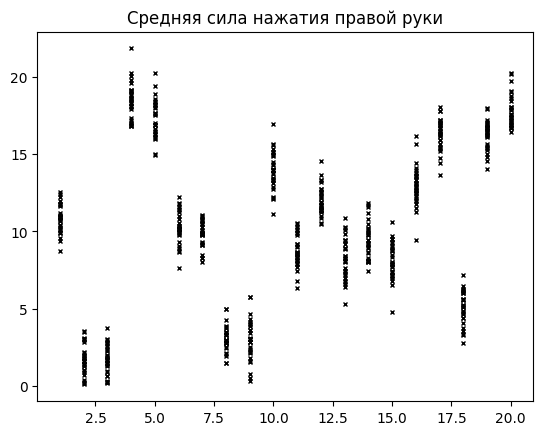

In [461]:
import matplotlib.pyplot as plt
import numpy as np

plt.title("Средняя сила нажатия правой руки")
plt.plot(x, y, 'x', color='black', markersize=3)

In [465]:
len(usersData[3])

30

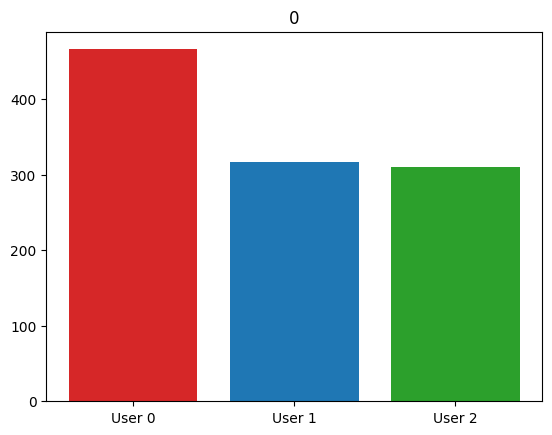

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fruits = ['User 0', 'User 1', 'User 2']
counts = tkek[0]
bar_colors = ['tab:red', 'tab:blue', 'tab:green']

ax.bar(fruits, counts, color=bar_colors)

ax.set_title('0')

plt.show()

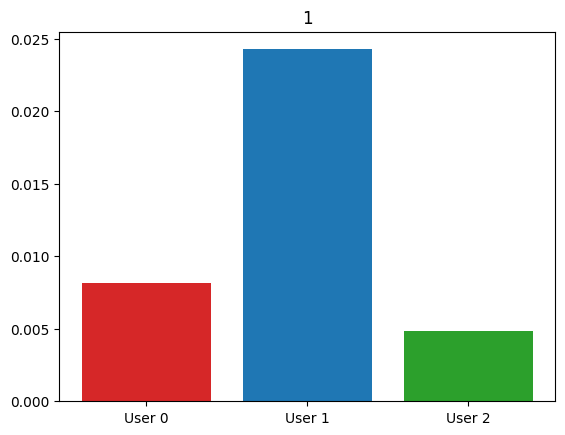

In [16]:
fig, ax = plt.subplots()
fruits = ['User 0', 'User 1', 'User 2']
counts = tkek[1]
bar_colors = ['tab:red', 'tab:blue', 'tab:green']

ax.bar(fruits, counts, color=bar_colors)

ax.set_title('1')

plt.show()

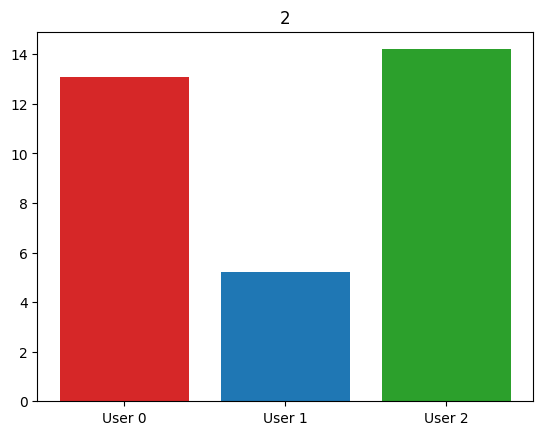

In [17]:
fig, ax = plt.subplots()
fruits = ['User 0', 'User 1', 'User 2']
counts = tkek[2]
bar_colors = ['tab:red', 'tab:blue', 'tab:green']

ax.bar(fruits, counts, color=bar_colors)

ax.set_title('2')

plt.show()

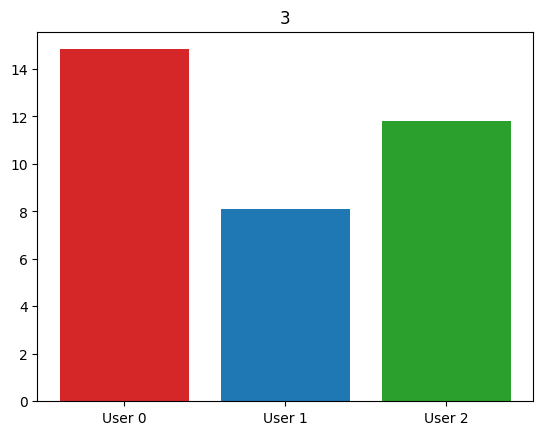

In [18]:
fig, ax = plt.subplots()
fruits = ['User 0', 'User 1', 'User 2']
counts = tkek[3]
bar_colors = ['tab:red', 'tab:blue', 'tab:green']

ax.bar(fruits, counts, color=bar_colors)

ax.set_title('3')

plt.show()

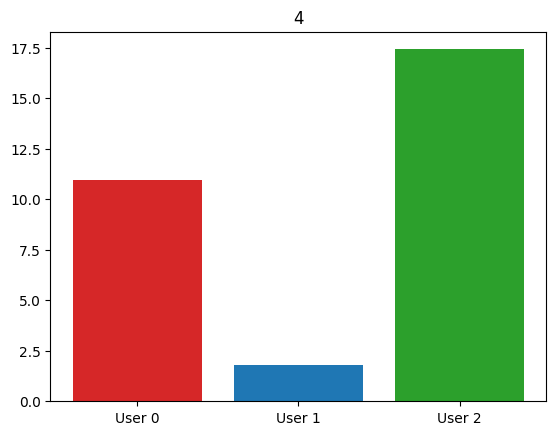

In [19]:
fig, ax = plt.subplots()
fruits = ['User 0', 'User 1', 'User 2']
counts = tkek[4]
bar_colors = ['tab:red', 'tab:blue', 'tab:green']

ax.bar(fruits, counts, color=bar_colors)

ax.set_title('4')

plt.show()